## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
#!pip install gym[atari]

In [1]:
from TCGame_Env import TicTacToe # import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
env = TicTacToe() # environemnt called as env

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    #epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random() 
    if z > epsilon:
        state_for_dict = Q_state(state)
        action = max(Q_dict[state_for_dict],key=Q_dict[state_for_dict].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        ValidActions = valid_actions(state)
        action = ValidActions[np.random.choice(range(len(ValidActions)))]    #Exploration: randomly choosing and action
    
    return action


#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
Q_dict_track=[]
States_track = collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(2,3)),('x-x-x-x-x-x-x-x-x',(5,4)),
                       ('x-x-x-x-3-x-5-x-x',(1,6)),('x-2-x-x-x-x-1-3-x',(4,6))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []     

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [11]:
EPISODES = 1000000
LR = 0.01
GAMMA = 0.91
threshold = 5000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 6000  
max_epsilon = 1.0
min_epsilon = 0.001

### Q-update loop ---write your code here

In [12]:
start_time = time.time()
curr_time = time.time()
rewards_track = []
total_rewards=0
for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe() # creating an instance of the class
    if episode % 10000 == 0:
        print("Time taken {} Episode: {} total rewards {}".format(round(time.time()-curr_time,2),episode,total_rewards))
        curr_time = time.time()
    curr_state = env.state
    add_to_dict(curr_state) # adding the current state to dictionary
    Reached_Terminal = False # this variable represents that the terminal state is not reached
    
    while Reached_Terminal != True: # continue till terminal state is reached
        curr_state_for_dict = Q_state(curr_state)

        curr_action = epsilon_greedy(curr_state, episode)
        reward, next_state, Reached_Terminal = env.step(curr_state, curr_action)
                
        next_state_for__dict = Q_state(next_state)
        add_to_dict(next_state)
        
        # UPDATE RULE
        
        if Reached_Terminal != True:
            max_next = max(Q_dict[next_state_for__dict],key=Q_dict[next_state_for__dict].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_for_dict][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_for__dict][max_next]))) 
                                                              - Q_dict[curr_state_for_dict][curr_action] ) 

        else:
            Q_dict[curr_state_for_dict][curr_action] += LR * ((reward - Q_dict[curr_state_for_dict][curr_action] )) 
            curr_state = next_state       #state transition
            total_rewards+=reward

          
    
    #TRACKING states
      
    if ((episode+1) % threshold) == 0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:
        save_obj(Q_dict,'Policy')
        Q_dict_track.append(Q_dict)
    # TRACKING REWARDS per episode
    if ((episode + 1)% policy_threshold ) == 0:
        rewards_track.append(total_rewards)
        total_rewards=0
#########################################################
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
elapsed_time
#########################################################

Time taken 0.0 Episode: 0 total rewards 0
Time taken 7.7 Episode: 10000 total rewards -1900
Time taken 7.85 Episode: 20000 total rewards -390
Time taken 8.01 Episode: 30000 total rewards 0
Time taken 7.83 Episode: 40000 total rewards -1370
Time taken 8.16 Episode: 50000 total rewards -1040
Time taken 8.37 Episode: 60000 total rewards 0
Time taken 7.89 Episode: 70000 total rewards -890
Time taken 8.65 Episode: 80000 total rewards -630
Time taken 8.72 Episode: 90000 total rewards 0
Time taken 8.01 Episode: 100000 total rewards -1440
Time taken 8.81 Episode: 110000 total rewards -1420
Time taken 9.06 Episode: 120000 total rewards 0
Time taken 8.3 Episode: 130000 total rewards -1480
Time taken 9.32 Episode: 140000 total rewards -450
Time taken 9.58 Episode: 150000 total rewards 0
Time taken 8.73 Episode: 160000 total rewards -1300
Time taken 9.57 Episode: 170000 total rewards -760
Time taken 9.74 Episode: 180000 total rewards 0
Time taken 8.42 Episode: 190000 total rewards -700
Time taken 

1065.8038756847382

#### Check the Q-dictionary

In [13]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2293032395072232,
              (0, 3): -1.2277313788890802,
              (0, 5): -1.2284328453644398,
              (0, 7): -1.2286915940218455,
              (0, 9): -1.229303612970498,
              (1, 1): -1.2282470790011355,
              (1, 3): -1.229477792602428,
              (1, 5): -1.2276347648130095,
              (1, 7): -1.2295086479521244,
              (1, 9): -1.2274361972099213,
              (2, 1): -1.2284095097213152,
              (2, 3): -1.2280234637037482,
              (2, 5): -1.2279580486371873,
              (2, 7): -1.2278682877939358,
              (2, 9): -1.2282137610367396,
              (3, 1): -1.2278888066014462,
              (3, 3): -1.2278931492074914,
              (3, 5): -1.2279491463842713,
              (3, 7): -1.227684699468594,
              (3, 9): -1.2280774703095305,
              (4, 1): -1.2281993504459519,
              (4, 3): -1.2276987679276472,
              (4, 

In [14]:
len(Q_dict)

1552530

In [46]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
test_current_state = '7-x-1-4-x-8-x-x-x'
best_move = max(Q_dict[test_current_state], key=Q_dict[test_current_state].get)
print("Data", test_current_state,best_move)
st = test_current_state.split("-")
r1=st[0:3]
r2=st[3:6]
r3=st[6:9]
print(r1)
print(r2)
print(r3) 
print("#########################################")
print("At location {}, player fills with {} ".format(best_move[0],best_move[1]))
print("#########################################")

Data 7-x-1-4-x-8-x-x-x (4, 3)
['7', 'x', '1']
['4', 'x', '8']
['x', 'x', 'x']
#########################################
At location 4, player fills with 3 
#########################################


#### Check the states tracked for Q-values convergence
(non-evaluative)

In [47]:
# Write the code for plotting the graphs for state-action pairs tracked

In [54]:
sample_q_values = [('x-8-4-x-1-6-5-7-x',(8, 3)),('x-8-4-x-1-6-5-7-x',(1, 5)),
                    ('9-x-1-4-x-8-x-x-x',(1, 5)),('7-x-1-4-x-8-x-x-x',(4, 3))] 
for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        print("\n#########\n",state,"\n",Q_dict_track[0][state])


#########
 x-8-4-x-1-6-5-7-x 
 {(0, 3): 0, (0, 9): 0, (3, 3): 0, (3, 9): 0, (8, 3): 0.1, (8, 9): 0}

#########
 x-8-4-x-1-6-5-7-x 
 {(0, 3): 0, (0, 9): 0, (3, 3): 0, (3, 9): 0, (8, 3): 0.1, (8, 9): 0}

#########
 9-x-1-4-x-8-x-x-x 
 {(1, 3): -0.01, (1, 5): 0, (1, 7): -0.01, (4, 3): 0, (4, 5): -0.01, (4, 7): 0, (6, 3): -0.01, (6, 5): 0, (6, 7): 0, (7, 3): 0, (7, 5): 0, (7, 7): -0.1, (8, 3): 0, (8, 5): -0.028791, (8, 7): 0}

#########
 7-x-1-4-x-8-x-x-x 
 {(1, 3): -0.1099, (1, 5): -0.01, (1, 9): -0.01, (4, 3): 0, (4, 5): -0.1, (4, 9): 0, (6, 3): -0.01, (6, 5): 0, (6, 9): 0, (7, 3): 0, (7, 5): 0, (7, 9): -0.01, (8, 3): 0, (8, 5): 0, (8, 9): -0.01}


### Epsilon - decay check

In [29]:
max_epsilon = 1.0
min_epsilon = 0.001
time_data = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

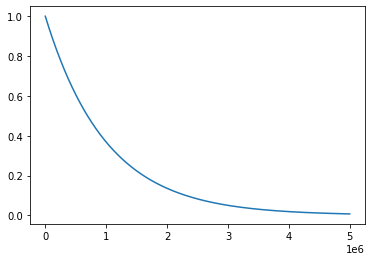

In [30]:
plt.plot(time_data, epsilon)
plt.show()

<AxesSubplot:xlabel='episode', ylabel='reward'>

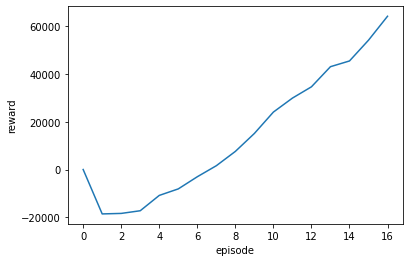

In [35]:
rewards_per_nth_events = []
total_rewrd=0
for idx in range(len(rewards_track)):
    if idx % 10:
        total_rewrd+= rewards_track[idx]
    else:
        rewards_per_nth_events.append(total_rewrd)
        total_rewrd=0
axs= [i for i in range(len(rewards_per_nth_events)) ]
d = {'episode': axs, 'reward': rewards_per_nth_events}
df = pd.DataFrame(d)
sns.lineplot(data=df,x='episode', y='reward')